In [1]:
import keras
import tensorflow as tf
import os
from keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from keras.layers import BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
from keras.models import Model
from sklearn.utils import shuffle
from cv2 import imread
import numpy as np
import pandas as pd
import re

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
PATH = r"C:\RP\DR\gaussian_filtered_images\gaussian_filtered_images"

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3662 files belonging to 5 classes.
Using 2747 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3662 files belonging to 5 classes.
Using 915 files for validation.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
class_names =['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
print(class_names)

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [9]:
data=[]
label=[]

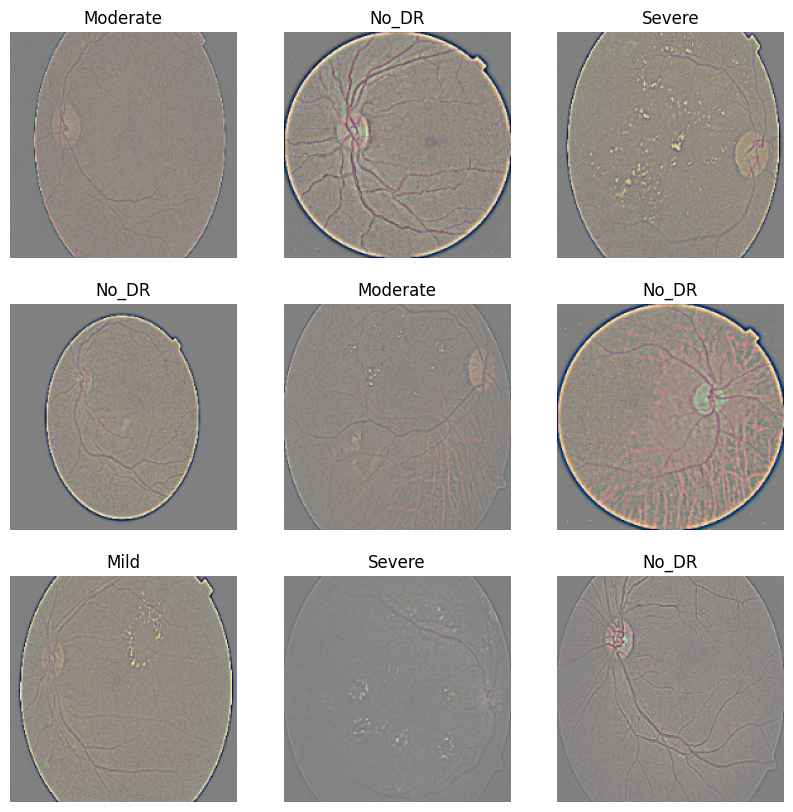

In [10]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    data.append(images)
    label.append(labels)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [15]:

epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
86/86 [==============================] - 10s 39ms/step - loss: 0.9656 - accuracy: 0.6349 - val_loss: 0.7782 - val_accuracy: 0.7180
Epoch 2/25
86/86 [==============================] - 2s 23ms/step - loss: 0.7745 - accuracy: 0.7084 - val_loss: 0.7638 - val_accuracy: 0.7257
Epoch 3/25
86/86 [==============================] - 2s 23ms/step - loss: 0.7341 - accuracy: 0.7295 - val_loss: 0.7425 - val_accuracy: 0.7311
Epoch 4/25
86/86 [==============================] - 2s 23ms/step - loss: 0.7057 - accuracy: 0.7295 - val_loss: 0.7152 - val_accuracy: 0.7366
Epoch 5/25
86/86 [==============================] - 2s 23ms/step - loss: 0.6580 - accuracy: 0.7532 - val_loss: 0.7192 - val_accuracy: 0.7344
Epoch 6/25
86/86 [==============================] - 2s 23ms/step - loss: 0.6228 - accuracy: 0.7674 - val_loss: 0.7386 - val_accuracy: 0.7377
Epoch 7/25
86/86 [==============================] - 2s 23ms/step - loss: 0.5801 - accuracy: 0.7790 - val_loss: 0.7550 - val_accuracy: 0.7279
Epoch 8/25
8

In [16]:
model.save('cnn_model.h5')

In [17]:
img=r"C:\RP\DR\gaussian_filtered_images\gaussian_filtered_images\Proliferate_DR\5b76117c4bcb.png"

In [18]:
img = tf.keras.utils.load_img(
    img, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Proliferate_DR with a 99.98 percent confidence.


In [19]:
data = []
labels = []
width,height=180,180

imagePaths = list(paths.list_images(PATH))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    #print(imagePath)
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)

data, labels = shuffle(data, labels)
print(labels)
print(data.shape)
print(labels.shape)

[[0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 ...
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]]
(3662, 180, 180, 3)
(3662, 5)


In [20]:
test_ratio = 0.25

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=test_ratio)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

Train images: (2746, 180, 180, 3)
Test images: (916, 180, 180, 3)
Train label: (2746, 5)
Test label: (916, 5)


[INFO] evaluating network...

Trainig Accuracy Score:- 91.62418062636563

Testing Accuracy Score:- 90.61135371179039

Traning Graph:- 
 


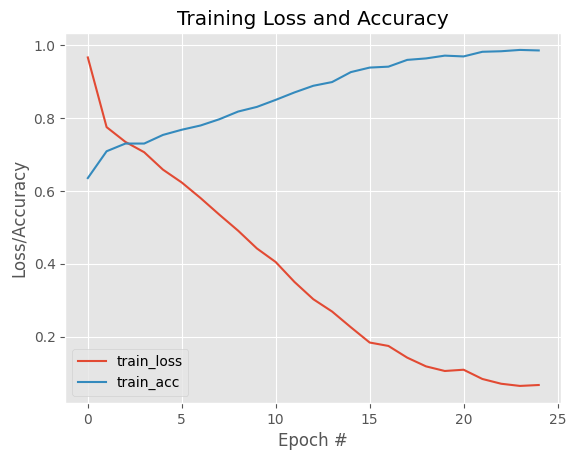

In [21]:

!pip install scikit-plot

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import metrics

print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)

trainpredIdxs = model.predict(x_train, batch_size=batch_size)
trainpredIdxs = np.argmax(trainpredIdxs, axis=1)

trainCNNScore=accuracy_score(trainpredIdxs,y_train.argmax(axis=1))*100
CNNScore=accuracy_score(predIdxs,y_test.argmax(axis=1))*100

print("\nTrainig Accuracy Score:-",trainCNNScore)
print("\nTesting Accuracy Score:-",CNNScore)
print("\nTraning Graph:- \n ")

# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left",)
plt.show()

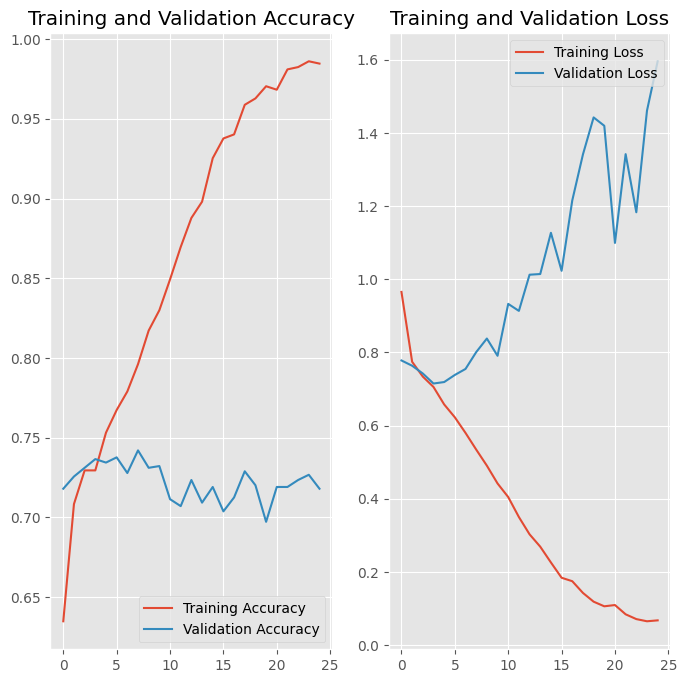

In [22]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

In [23]:
y_pred = model.predict(x_test)

In [24]:

extractCNN = Model(model.inputs, model.layers[-2].output)

del(data)
del(labels)
feat_trainCNN  = extractCNN.predict(x_train)  
feat_testCNN = extractCNN.predict(x_test)      

print(feat_trainCNN.shape)

(2746, 128)


In [25]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(feat_trainCNN,np.argmax(y_train,axis=1))

TrainSVMScoreCNN=svm.score(feat_trainCNN,np.argmax(y_train,axis=1))*100
print("SVM Training Accuracy Score:-",TrainSVMScoreCNN)

TestSVMScoreCNN=svm.score(feat_testCNN,np.argmax(y_test,axis=1))*100
print("\nSVM Testing Accuracy Score:-",TestSVMScoreCNN)

SVM Training Accuracy Score:- 93.84559359067734

SVM Testing Accuracy Score:- 88.53711790393012


In [26]:
model.save('cnnSVM_model.h5')

In [27]:

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(feat_trainCNN,np.argmax(y_train,axis=1))

TrainDecisionScoreCNN=clf.score(feat_trainCNN,np.argmax(y_train,axis=1))*100
print("Decision Tree Training Accuracy Score:-",TrainDecisionScoreCNN)


TestDecisionScoreCNN=clf.score(feat_testCNN,np.argmax(y_test,axis=1))*100
print("\nDecision Tree Testing Accuracy Score:-",TestDecisionScoreCNN)

Decision Tree Training Accuracy Score:- 99.30808448652586

Decision Tree Testing Accuracy Score:- 80.24017467248909


In [28]:
model.save('cnnCLF_model.h5')

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(feat_trainCNN,np.argmax(y_train,axis=1))

TrainKNNScoreCNN=knn.score(feat_trainCNN,np.argmax(y_train,axis=1))*100
print("KNN Training Accuracy Score:-",TrainKNNScoreCNN)

TestKNNScoreCNN=knn.score(feat_testCNN,np.argmax(y_test,axis=1))*100
print("\nKNN Testing Accuracy Score:-",TestKNNScoreCNN)

KNN Training Accuracy Score:- 92.60742898761836

KNN Testing Accuracy Score:- 88.20960698689956


In [30]:
model.save('cnnKNN_model.h5')

In [31]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(feat_trainCNN,np.argmax(y_train,axis=1))

TrainNBScoreCNN=gnb.score(feat_trainCNN,np.argmax(y_train,axis=1))*100
print("\nGaussianNaive Bayes Training Accuracy Score:-",TrainNBScoreCNN)

TestNBScoreCNN=gnb.score(feat_testCNN,np.argmax(y_test,axis=1))*100
print("\nGaussianNaive Bayes Testing Accuracy Score:-",TestNBScoreCNN)


GaussianNaive Bayes Training Accuracy Score:- 82.01019664967225

GaussianNaive Bayes Testing Accuracy Score:- 80.89519650655022


In [32]:
model.save('cnnKNN_model.h5')

In [33]:

print("--Training Accuracy..")
print("CNN Accuracy:- {:.2f} %".format(trainCNNScore))
print("CNN-SVM Accuracy:- {:.2f} %".format(TrainSVMScoreCNN))
print("CNN-DT Accuracy:- {:.2f} %".format(TrainDecisionScoreCNN))
print("CNN-KNN Accuracy:- {:.2f} %".format(TrainKNNScoreCNN))
print("CNN-NB Accuracy:- {:.2f} %".format(TrainNBScoreCNN))

print("\n--Testing Accuracy..")
print("CNN Accuracy:- {:.2f} %".format(CNNScore))
print("CNN-SVM Accuracy:- {:.2f} %".format(TestSVMScoreCNN))
print("CNN-DT Accuracy:- {:.2f} %".format(TestDecisionScoreCNN))
print("CNN-KNN Accuracy:- {:.2f} %".format(TestKNNScoreCNN))
print("CNN-NB Accuracy:- {:.2f} %".format(TestNBScoreCNN))

--Training Accuracy..
CNN Accuracy:- 91.62 %
CNN-SVM Accuracy:- 93.85 %
CNN-DT Accuracy:- 99.31 %
CNN-KNN Accuracy:- 92.61 %
CNN-NB Accuracy:- 82.01 %

--Testing Accuracy..
CNN Accuracy:- 90.61 %
CNN-SVM Accuracy:- 88.54 %
CNN-DT Accuracy:- 80.24 %
CNN-KNN Accuracy:- 88.21 %
CNN-NB Accuracy:- 80.90 %


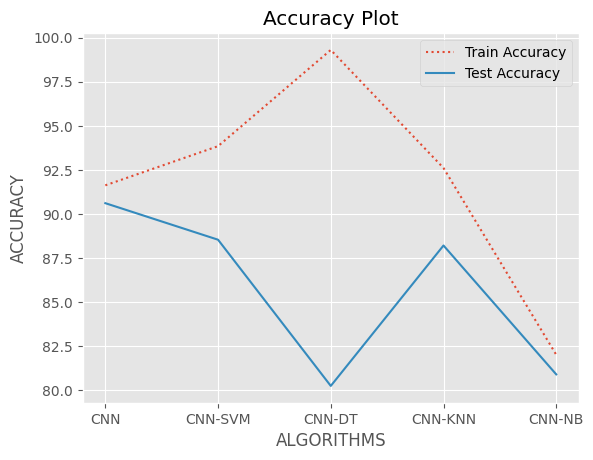

In [34]:

trainpoints =  np.array([trainCNNScore,TrainSVMScoreCNN,TrainDecisionScoreCNN,TrainKNNScoreCNN,TrainNBScoreCNN])
testpoints = np.array([CNNScore,TestSVMScoreCNN,TestDecisionScoreCNN,TestKNNScoreCNN,TestNBScoreCNN])
labels=np.array(["CNN","CNN-SVM","CNN-DT","CNN-KNN","CNN-NB"])
plt.plot(labels,trainpoints, linestyle = 'dotted',label = "Train Accuracy")

plt.plot(labels,testpoints, linestyle = 'solid',label= "Test Accuracy")
plt.title("Accuracy Plot")
plt.xlabel("ALGORITHMS")
plt.ylabel("ACCURACY")
plt.legend()
plt.show()